# Kaggle - Titanic Dataset

The notebook looks at exploring the Titatic dataset on Kaggle to predict whether a passenger survived the accident or not.

In [1]:
%matplotlib inline

import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder

Load in the data

In [2]:
df = pd.read_csv(
    './data/train.csv',
    header=0,
)

In [3]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
len(df)

891

In [5]:
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

The dataset is imbalanced, but not enough I don't think to have an impact on performance.

A quick scatter matrix of all the columns plotted against all of the other columns with the dots coloured by whether the passenger survived (1) or not (0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1913CAF0>,
      dtype=object)

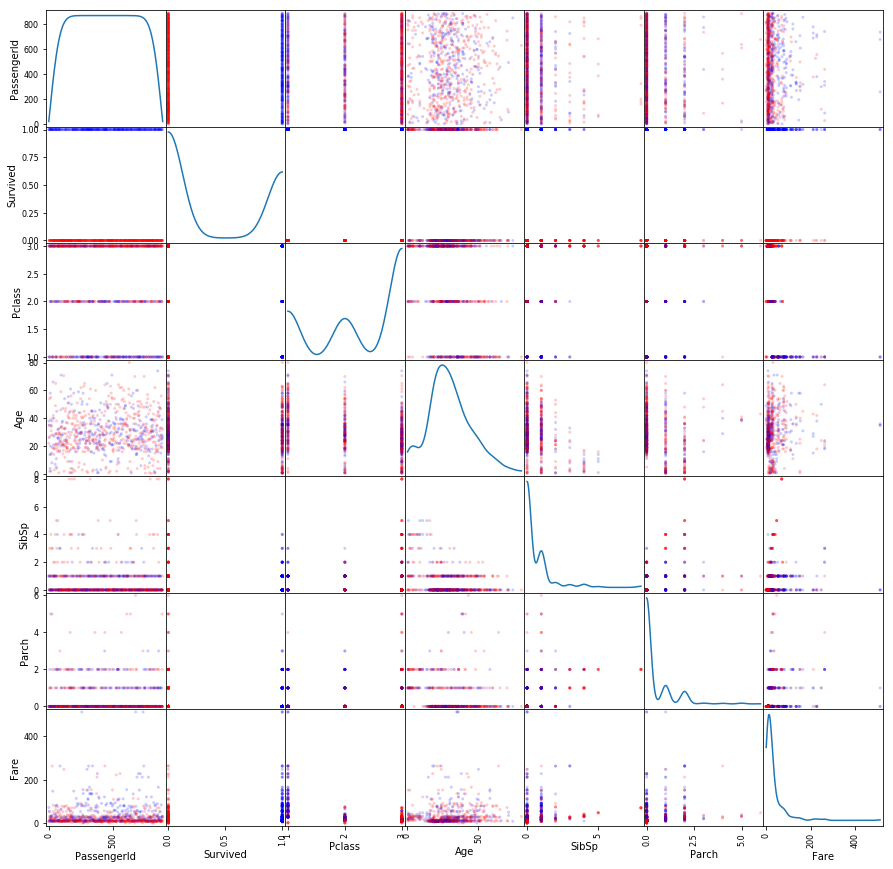

In [6]:
colours = ['blue' if i == 1 else 'red' for i in df['Survived']]
scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde', color=colours)

Looks like we have lots of categorical data along with a couple of numerical features. Name sex and ticket are not showing in the plot, due to these columns being strings

### Sex

Let's looks how the numbers of passengers who survived broken down by `Sex`

In [7]:
pd.crosstab(df['Sex'], df['Survived'], normalize='index')

Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908


wow, looks like 74% of females survived compared to only 18% of males. This could be an important feature.

### Pclass

Looking at the survival rate of `Pclass`:

In [8]:
pd.crosstab(df['Pclass'], df['Survived'], normalize='index')

Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363


Looks like `Pclass` also had an impact on survival rates.

### Sibsp and Parch

The `SibSp` and `Parch` could also contain usefull information as it contains information regarding siblings and partners

In [9]:
df['family_size'] = df['SibSp'] + df['Parch'] + 1 # + 1 needed to include lone travellers
pd.crosstab(df['family_size'], df['Survived'], normalize='index')

Survived,0,1
family_size,,
1,0.696462,0.303538
2,0.447205,0.552795
3,0.421569,0.578431
4,0.275862,0.724138
5,0.800000,0.200000
6,0.863636,0.136364
7,0.666667,0.333333
8,1.000000,0.000000
11,1.000000,0.000000


In [10]:
df['family_size'].value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: family_size, dtype: int64

Larger families, generally, are less likely to survive (although there are less of them)

Let's look at the survival rates of passnegers who travelled alone:

In [11]:
df['is_alone'] = np.where(df['family_size'] == 1, 1, 0) # 1 = alone, 0 = not alone
pd.crosstab(df['is_alone'], df['Survived'], normalize='index')

Survived,0,1
is_alone,,
0,0.494350,0.505650
1,0.696462,0.303538


There seems to be a considerable impact on travelling alone!

### Age

Let's take a look at age now. There seems to be a lot of missing values in `Age` so we will generate the ages with random numbers within 1 standard deviation of the age mean.

In [12]:
df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [13]:
df['Age'].isnull().sum()

177

177 passengers don't have any ages. 

What does the distribution of survival rates of the ages look like:

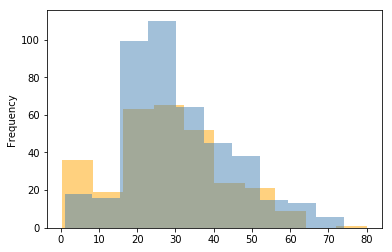

In [14]:
df['Age'][df['Survived'] == 1].plot(kind='hist', alpha=0.5, color='orange')
df['Age'][df['Survived'] == 0].plot(kind='hist', alpha=0.5, color='steelblue')

Interesting, some difference. Younger passengers survived (orange) and more middle aged passengers perished.

In [15]:
age_avg = df['Age'].mean()
age_std = df['Age'].std()
age_null_count = df['Age'].isnull().sum()

In [16]:
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)

In [17]:
df['Age'][np.isnan(df['Age'])] = age_null_random_list
df['Age'] = df['Age'].astype(int)

c:\users\harpal\envs\datascience\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
df['Age'].isnull().sum()

0

In [19]:
df['binned_age'] = pd.cut(df['Age'], 5) # Bin the ageses in 5 bins
pd.crosstab(df['binned_age'], df['Survived'], normalize='index')

Survived,0,1
binned_age,,
"(-0.08, 16.0]",0.471698,0.528302
"(16.0, 32.0]",0.644796,0.355204
"(32.0, 48.0]",0.627376,0.372624
"(48.0, 64.0]",0.565217,0.434783
"(64.0, 80.0]",0.909091,0.090909


The binned ages shed some more light on how aged may impacted survival. 

### Name

The title of the person suggests the person's status and may indicate be a potential feature in survival prediction

In [20]:
def extract_title(name: str) -> str:
    """
    Extract the title in the name
    """
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ''

In [21]:
df['title'] = df['Name'].apply(extract_title)

Look the the frequency of titles broken down by `Sex`

In [22]:
pd.crosstab(df['title'], df['Sex'])

Sex,female,male
title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


Survival rate by `Title`:

In [23]:
pd.crosstab(df['title'], df['Survived'], normalize='index')

Survived,0,1
title,,
Capt,1.000000,0.000000
Col,0.500000,0.500000
Countess,0.000000,1.000000
Don,1.000000,0.000000
Dr,0.571429,0.428571
Jonkheer,1.000000,0.000000
Lady,0.000000,1.000000
Major,0.500000,0.500000
Master,0.425000,0.575000


Definitely, looks like there is a correlation here. There are a lot of them though, so let's group the titles together and additionaly normalise them:

In [24]:
df['title'] = df['title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['title'] = df['title'].replace('Mlle', 'Miss')
df['title'] = df['title'].replace('Ms', 'Miss')
df['title'] = df['title'].replace('Mme', 'Mrs')

In [25]:
pd.crosstab(df['title'], df['Survived'], normalize='index')

Survived,0,1
title,,
Master,0.425000,0.575000
Miss,0.297297,0.702703
Mr,0.843327,0.156673
Mrs,0.206349,0.793651
Rare,0.652174,0.347826


### Fare

Fare also has some missing value and we will replace it with the median and then categorize it into 4 ranges.

In [26]:
df['Fare'] = df['Fare'].fillna(df['Fare'].median())
df['fare_binned'] = pd.qcut(df['Fare'], 4)

In [27]:
pd.crosstab(df['fare_binned'], df['Survived'], normalize='index')

Survived,0,1
fare_binned,,
"(-0.001, 7.91]",0.802691,0.197309
"(7.91, 14.454]",0.696429,0.303571
"(14.454, 31.0]",0.545045,0.454955
"(31.0, 512.329]",0.418919,0.581081


Looks like the higher the fare a passenger paid the more likely you were to survive. This again is probably associated with class

### Embarked


In [28]:
pd.crosstab(df['Embarked'], df['Survived'], normalize='index')

Survived,0,1
Embarked,,
C,0.446429,0.553571
Q,0.610390,0.389610
S,0.663043,0.336957


### Cabin

In [29]:
df['Cabin'].value_counts()

G6                 4
B96 B98            4
C23 C25 C27        4
F2                 3
E101               3
F33                3
C22 C26            3
D                  3
B35                2
C78                2
E24                2
B20                2
C52                2
D20                2
B22                2
C93                2
C124               2
E8                 2
F G73              2
B28                2
C68                2
B77                2
E121               2
C65                2
D35                2
B57 B59 B63 B66    2
E33                2
D17                2
B51 B53 B55        2
B5                 2
                  ..
T                  1
B42                1
A26                1
D11                1
A34                1
C106               1
B50                1
F G63              1
B86                1
C101               1
E63                1
B78                1
E10                1
C91                1
D56                1
A5                 1
B101         

In [30]:
df['Cabin'].isnull().sum()

687

Doesn't look like `Cabin` will be useful here. A lot of them only occur once and a lot of passengers have no associated `Cabin`.

With some inital data exploration complete, let's now create a pipeline to engineer the features and clean the data.

## Pipline

Here we have a series of functions to perform the necessary feature engineering

In [31]:

def map_sex(df: pd.DataFrame) -> pd.DataFrame:
    """
    Map Sex to int
    """
    df['Sex'] = df['Sex'].map({'female': 0, 'male': 1}).astype(int)
    return df

def map_embarked(df: pd.DataFrame) -> pd.DataFrame:
    """
    Map embarked location to int
    """
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2, np.nan: 0}).astype(int)
    return df


def extract_title(name: str) -> str:
    """
    Extract the title in the name
    """
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ''

def replace_title(df: pd.DataFrame) -> pd.DataFrame:
    """
    Replace the extracted titles
    """
    title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
    df['title'] = df['Name'].apply(extract_title)
    df['title'] = df['title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['title'] = df['title'].replace('Mlle', 'Miss')
    df['title'] = df['title'].replace('Ms', 'Miss')
    df['title'] = df['title'].replace('Mme', 'Mrs')
    df['title'] = df['title'].map(title_mapping)
    df['title'] = df['title'].fillna(0)
    return df

def create_family_size(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create family size feature
    """
    df['family_size'] = df['SibSp'] + df['Parch'] + 1
    return df

def create_is_alone(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create is alone feature
    """
    df['is_alone'] = np.where(df['family_size'] == 1, 1, 0)
    return df

def create_binned_age(df: pd.DataFrame, train=False) -> pd.DataFrame:
    """
    Create binned age
    """        
    df.loc[ df['Age'] <= 16, 'Age'] = 0
    df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age'] = 1
    df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age'] = 2
    df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age'] = 3
    df.loc[ df['Age'] > 64, 'Age'] = 4
    df['Age'] = df['Age'].astype(int)
    return df

def create_binned_fare(df: pd.DataFrame) -> pd.DataFrame:
    """
    create binned fare
    """
    df.loc[ df['Fare'] <= 7.91, 'Fare'] = 0
    df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
    df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare'] = 2
    df.loc[ df['Fare'] > 31, 'Fare'] = 3
    df['Fare'] = df['Fare'].astype(int)
    return df

In [32]:
def transform_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Applies all of the feature engineering steps
    """
    df = map_sex(df)
    df = map_embarked(df)
    df = replace_title(df)
    df = create_family_size(df)
    df = create_is_alone(df)
    df = create_binned_age(df)
    df = create_binned_fare(df)
    return df 

Import the necessary modules to build and assess a RandomForest model

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
    StratifiedKFold,
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

import warnings
warnings.filterwarnings('ignore')

In [34]:
train = pd.read_csv('./data/train.csv',header=0)
y = train['Survived']
train = train.drop(columns=['Survived'])

Create two CV's and outter and an innter for nested cross-validation

In [35]:
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Initialise a `RandomForestClassifier` class and param_grid for searching

In [36]:
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [5, 10, 20, 50],
    'criterion': ['entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['auto']
}

Create the splits for the outter CV and perform the feature engineering. 4/5 folds enter the inner CV on which the grid search is performed. The best parameters per grid search are then used on the fold left out to assess performance on data it has never seen or predicted on before.

In [37]:
COLUMNS = [
    'Pclass',
    'Sex',
    'Age',
    'Fare',
    'Embarked',
    'title',
    'family_size',
    'is_alone',
]

for train_index, test_index in outer_cv.split(train, y):
    train_data = train.iloc[train_index]
    train_y = y.iloc[train_index]
    test_data = train.iloc[test_index]
    test_y = y.iloc[test_index]
    
    
    # Need to keep create the mean and std per training fold as we don't want to leak information about the data into the test fold. The would happend if this
    # was calculated on the entire training data set
    train_age_avg = train_data['Age'].mean()
    train_age_std = train_data['Age'].std()
    train_age_null_count = train_data['Age'].isnull().sum()
    train_age_null_random_list = np.random.randint(train_age_avg - train_age_std, train_age_avg + train_age_std, size=train_age_null_count)
    train_data['Age'][np.isnan(train_data['Age'])] = train_age_null_random_list
    train_data['Age'] = train_data['Age'].astype(int)
    train_data = transform_data(train_data)

    # Using the mean and std learnt from the training folder apply the same to the test fold
    test_age_null_count = test_data['Age'].isnull().sum()
    test_age_null_random_list = np.random.randint(train_age_avg - train_age_std, train_age_avg + train_age_std, size=test_age_null_count)
    test_data['Age'][np.isnan(test_data['Age'])] = test_age_null_random_list
    test_data['Age'] = test_data['Age'].astype(int)
    test_data = transform_data(test_data)
    
    train_data = train_data[COLUMNS]
    test_data = test_data[COLUMNS]
    
    gc = GridSearchCV(estimator=rf, param_grid=param_grid, cv=inner_cv, n_jobs=8)
    gc.fit(train_data, train_y)
    test_pred = gc.predict(test_data)
    print('\n========================')
    print(gc.best_params_)
    print(f'Accuracy: {accuracy_score(test_y, test_pred)}')
    print(f'Precision: {precision_score(test_y, test_pred)}')
    print(f'Recall: {recall_score(test_y, test_pred)}')
    print(f'F1: {f1_score(test_y, test_pred)}')
    print(f'Confusion Matrix: {confusion_matrix(test_y, test_pred)}')




{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 50}
Accuracy: 0.8379888268156425
Precision: 0.803030303030303
Recall: 0.7681159420289855
F1: 0.785185185185185
Confusion Matrix: [[97 13]
 [16 53]]

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.7877094972067039
Precision: 0.7818181818181819
Recall: 0.6231884057971014
F1: 0.6935483870967741
Confusion Matrix: [[98 12]
 [26 43]]

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 50}
Accuracy: 0.8202247191011236
Precision: 0.78125
Recall: 0.7352941176470589
F1: 0.7575757575757576
Confusion Matrix: [[96 14]
 [18 50]]

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 50}
Accuracy: 0.8707865168539326
Precision: 0.8688524590163934
Recall: 0.7794117647058824
F1: 0.8217054263565892
Confusion Matrix: [[102

The results on the test set overall look pretty good. We achieve the highest overall performance on fold 4 with the following parameters:
```
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 10, 'n_estimators': 50}
```

The `max_depth` and `n_estimators` are generally agreed across each fold, where as `min_samples_split` is not. I'm tempted to keep this at `10` to act as form of regularisation.

Let's take the above best parameters and train a model on all the data and assess it with out-of-bag performance.

In [38]:
clf = RandomForestClassifier(
    criterion='entropy',
    max_depth=5,
    max_features='auto',
    min_samples_split=10,
    n_estimators=50,
    oob_score=True,
)

In [39]:
train = pd.read_csv('./data/train.csv',header=0)
y = train['Survived']
train = train.drop(columns=['Survived'])

In [40]:
train_age_avg = train['Age'].mean()
train_age_std = train['Age'].std()
train_age_null_count = train['Age'].isnull().sum()
train_age_null_random_list = np.random.randint(train_age_avg - train_age_std, train_age_avg + train_age_std, size=train_age_null_count)
train['Age'][np.isnan(train['Age'])] = train_age_null_random_list
train['Age'] = train['Age'].astype(int)
train = transform_data(train)
train = train[COLUMNS]

In [41]:
train.head(5)

,Pclass,Sex,Age,Fare,Embarked,title,family_size,is_alone
0,3,1,1,0,0,1,2,0
1,1,0,2,3,1,3,2,0
2,3,0,1,1,0,2,1,1
3,1,0,2,3,0,3,2,0
4,3,1,2,1,0,1,1,1


In [42]:
clf = clf.fit(train, y)

In [43]:
clf.oob_score_ 

0.8316498316498316

Not bad. 82% accurate

Let's run this on the test data and sumbit it to Kaggle

In [44]:
test_kaggle = pd.read_csv('./data/test.csv',header=0)
passenger_id = test_kaggle['PassengerId']

In [45]:
test_kaggle.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [46]:
test_kaggle_age_null_count = test_kaggle['Age'].isnull().sum()
test_kaggle_age_null_random_list = np.random.randint(train_age_avg - train_age_std, train_age_avg + train_age_std, size=test_kaggle_age_null_count)
test_kaggle['Age'][np.isnan(test_kaggle['Age'])] = test_kaggle_age_null_random_list
test_kaggle['Age'] = test_kaggle['Age'].astype(int)
test_kaggle['Fare'] = test_kaggle['Fare'].fillna(train['Fare'].median())
test_kaggle = transform_data(test_kaggle)
test_kaggle = test_kaggle[COLUMNS]

In [47]:
test_kaggle.head(5)

,Pclass,Sex,Age,Fare,Embarked,title,family_size,is_alone
0,3,1,2,0,2,1,1,1
1,3,0,2,0,0,3,2,0
2,2,1,3,1,2,1,1,1
3,3,1,1,1,0,1,1,1
4,3,0,1,1,0,3,3,0


In [48]:
test_kaggle_preds = clf.predict(test_kaggle)

In [49]:
pd.DataFrame({'PassengerId': passenger_id, 'Survived': test_kaggle_preds}).to_csv('test_kaggle_predictions_random_forest.csv', sep=',', header=True, index=False)

#### The above submission scores 0.79 ~ 2551th (Top 24%)

The data used in training the model is essentially now categorical. These should be one-hot-encoded to ensure the classifier treats this as categories and not as continuous features

In [50]:
from sklearn.preprocessing import OneHotEncoder

In [51]:
enc = OneHotEncoder(handle_unknown='ignore')
enc = enc.fit(train)
enc.get_feature_names()

array(['x0_1', 'x0_2', 'x0_3', 'x1_0', 'x1_1', 'x2_0', 'x2_1', 'x2_2',
       'x2_3', 'x2_4', 'x3_0', 'x3_1', 'x3_2', 'x3_3', 'x4_0', 'x4_1',
       'x4_2', 'x5_1', 'x5_2', 'x5_3', 'x5_4', 'x5_5', 'x6_1', 'x6_2',
       'x6_3', 'x6_4', 'x6_5', 'x6_6', 'x6_7', 'x6_8', 'x6_11', 'x7_0',
       'x7_1'], dtype=object)

In [52]:
train_encoded = enc.transform(train)

In [53]:
clf = clf.fit(train_encoded, y)
clf.oob_score_ 

0.8204264870931538

In [54]:
test_kaggle_encoded = enc.transform(test_kaggle)

In [55]:
test_kaggle_preds_encoded = clf.predict(test_kaggle_encoded)

In [56]:
pd.DataFrame({'PassengerId': passenger_id, 'Survived': test_kaggle_preds_encoded}).to_csv('test_kaggle_predictions_random_forest_encoded.csv', sep=',', header=True, index=False)

#### The above submission scores 0.79904 ~ 1811th (Top 17%)

Looks like one-hot-encoding the data makes a big difference!